# Diversity Condition Violated Correct Model

This is a notebook that performs the experiment when the diversity condition is violated and we select a correct model to adjust for that.

- $p(\tilde{z}|z) = \delta(u - u') \frac{e^{\kappa}\tilde{z}^{T}z}{\int_{W(z)}e^{\kappa z^{T}z'}dz'}$ - model conditional density
- $q_{h}(\tilde{z}|z) = \delta(u-u') \frac{e^{\frac{1}{\tau} h(\tilde{z})^{T}h(z)}}{\int_{W(z)}e^{\frac{1}{\tau}h(z)^{T}h(z')}dz'}$ - Model conditional density

The loss function in this setup will be the following:

$\mathcal{L} = \mathbb{E}_{(z, \tilde{z}) \sim p(z, \tilde{z}), \{z^{-}_{i}\} \sim U(\mathcal{W}(z)) }[- \log(\frac{e^{\frac{1}{\tau}h(\tilde{z})^{T}h(z)}}{\Sigma_{i=1}^{M}e^{\frac{1}{\tau} h(\tilde{z})^{T}h(z^{-}_{i})}})]$

The plan is to do the experiments with the following data generating processess:

- 

In [7]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

import torch
from torch import nn
from torch import functional
from pathlib import Path

from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side, scatter3d_sphere
import matplotlib.pyplot as plt
from evals.disentanglement import linear_disentanglement, permutation_disentanglement
from visualization_utils.scoring import plot_scores

from simclr.simclr import SimCLRAdjusted

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)

d_fix = 1
d = 3
tau = 0.3
kappa = 1 / tau
batch_size = 2000
neg_samples = 1000
iterations = 5000

# Create figures directory
figures_dir = Path('figures')
figures_dir.mkdir(exist_ok=True)

# Sampling negative samples in the case where the model of the latent space has violated diversity condition, but our model adjusts for that
def sample_negative_samples(Z, M):
    z_fixed = Z[:, :d_fix].to(device)

    radii = torch.sqrt(1 - (z_fixed ** 2).sum(dim=1)).to(device)  # Radius of the sub-sphere
    neg_samples = torch.randn(Z.shape[0], M, d - d_fix, device=device)

    neg_samples = neg_samples / (neg_samples.norm(dim=2, keepdim=True) + 1e-8)  # Normalize the samples + add some margin for error
    neg_samples = neg_samples * radii.view(-1, 1, 1)

    return torch.cat((z_fixed.unsqueeze(1).expand(-1, M, -1), neg_samples), dim=2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:, :u_dim].to(device)
    v = z[:, u_dim:].to(device)

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2).to(device)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch).to(device) * torch.norm(v, p=2, dim=-1, keepdim=True).to(device)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch).to(device)  # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)

sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, d_fix)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using device:", device)

torch.cuda.empty_cache()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Visualizing the sampling processess

- Uniform Sampling
- Conditional Sampling
- Negative sample sampling

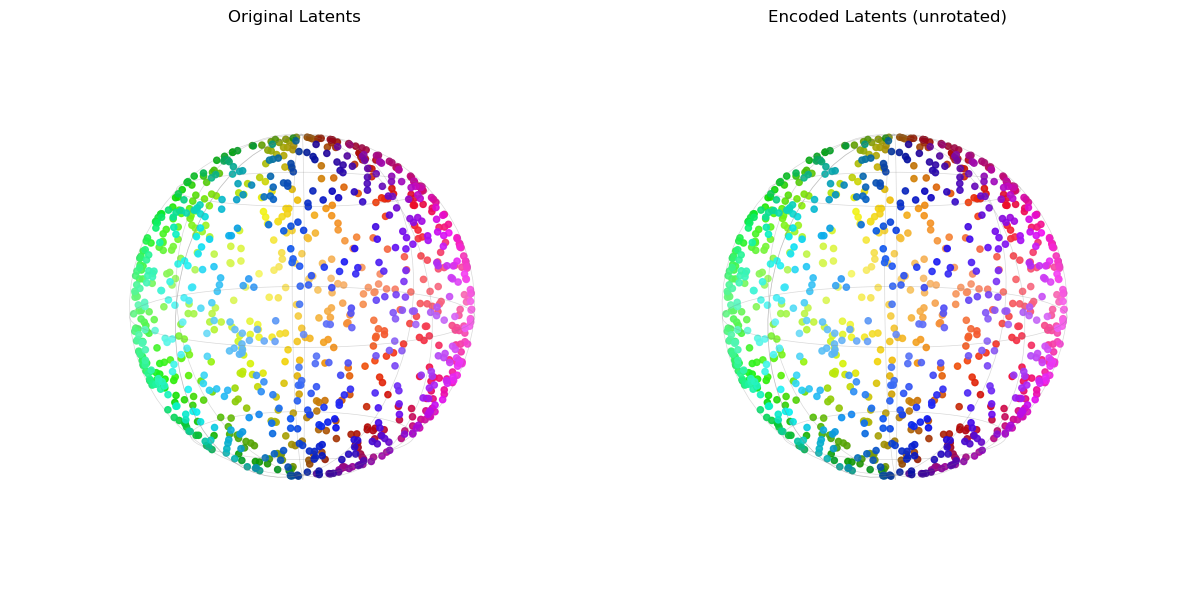

In [8]:
## Uniform sampling

s = full_sphere.uniform(1000)

fig = visualize_spheres_side_by_side(plt, s, s)
fig.savefig(figures_dir / 'uniform_sampling.png', dpi=150, bbox_inches='tight')
plt.show()

tensor([-0.4250,  0.0258, -0.9048])


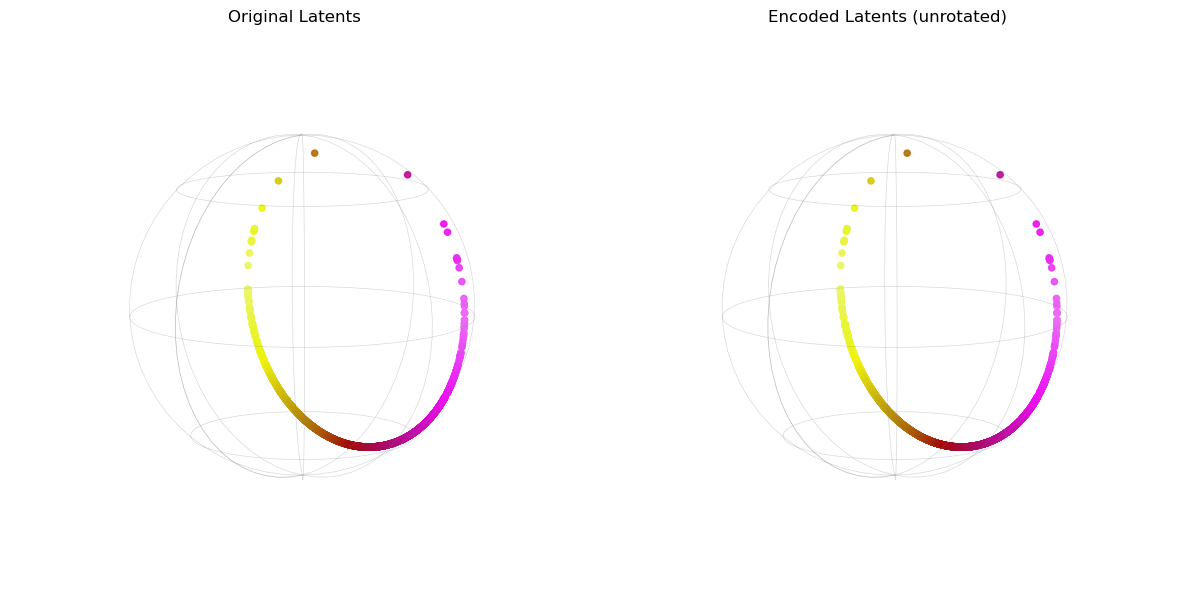

In [9]:
## Visualizing similar sample sampling

z = full_sphere.uniform(1).squeeze(0)

print(z)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, 2000) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(2000, 1), aug_samples_v), dim=-1)

fig = visualize_spheres_side_by_side(plt, z_aug, z_aug)
fig.savefig(figures_dir / 'similar_sample_sampling.png', dpi=150, bbox_inches='tight')
plt.show()

z shape: tensor([[ 0.9627, -0.2694, -0.0232]])
SHAPE OF NEGATIVE SAMPLES torch.Size([1000, 3])
MAX tensor(1., device='cuda:0')
MIN tensor(1.0000, device='cuda:0')


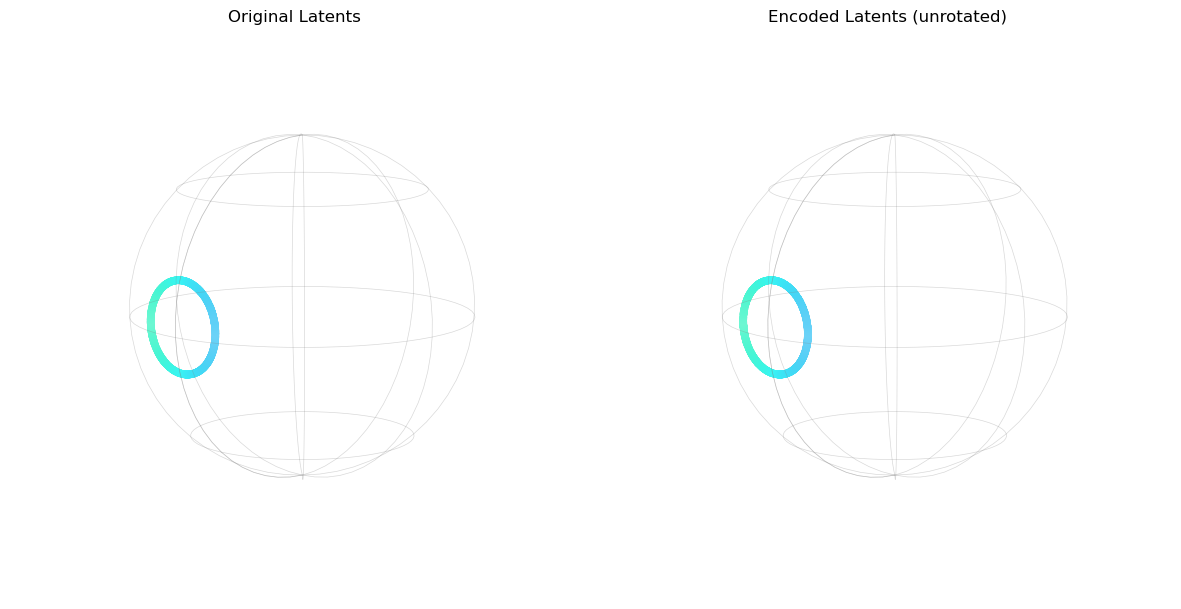

In [10]:
## Visualizing the negative sample sampling

z = full_sphere.uniform(1)

print("z shape:", z)

negative_samples = sample_negative_samples(z, 1000).squeeze(0)

print('SHAPE OF NEGATIVE SAMPLES', negative_samples.shape)
print("MAX", (negative_samples ** 2).sum(dim=1).max())
print("MIN", (negative_samples ** 2).sum(dim=1).min())

fig = visualize_spheres_side_by_side(plt, negative_samples, negative_samples)
fig.savefig(figures_dir / 'negative_sample_sampling.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
from encoders import SphericalEncoder
from simclr.simclr import SimCLRAdjusted
from experiment_utils.linear import linear_unrotation


torch.cuda.empty_cache()

f = SphericalEncoder(input_dim=3, hidden_dims=[128, 256, 256, 256, 256, 256, 256, 128], output_dim=3)
g_id = nn.Identity()


f, scores = SimCLRAdjusted(neg_samples, g_id, f, sample_pair_fixed, sample_negative_samples, tau, device).train(batch_size, iterations)

fig_scores = plot_scores(plt, scores)
fig_scores.savefig(figures_dir / 'identity_training_scores.png', dpi=150, bbox_inches='tight')
plt.show()

h = lambda z: f(g_id(z))
z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

fig = visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())
fig.savefig(figures_dir / 'identity_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

z = full_sphere.uniform(100000).to(device)
z_enc = h(z)

fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)
fig.savefig(figures_dir / 'identity_original.png', dpi=150, bbox_inches='tight')
plt.show()

fig = scatter3d_sphere(plt, z.cpu(), z_enc.cpu(), s=10, a=.8)
fig.savefig(figures_dir / 'identity_encoded.png', dpi=150, bbox_inches='tight')
plt.show()

# Unrotation
z_unrotated = linear_unrotation(z, z_enc)
fig = scatter3d_sphere(plt, z.cpu(), z_unrotated, s=10, a=.8)
fig.savefig(figures_dir / 'identity_unrotated.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
from data.generation import InjectiveLinearDecoder
from encoders import construct_mlp_encoder
from experiment_utils.linear import linear_unrotation

def perform_linear_experiment(data_dim):
    exp_name = f'linear{data_dim}d'
    
    g_linear = InjectiveLinearDecoder(3, data_dim)
    f = construct_mlp_encoder(data_dim, 3)

    sim_clr = SimCLRAdjusted(
        neg_samples=neg_samples,
        decoder=g_linear,
        encoder=f,
        sample_pair=sample_pair_fixed,
        sample_negative=sample_negative_samples,
        tau=tau,
        device=device
    )

    f, scores = sim_clr.train(
        batch_size=batch_size,
        iterations=iterations,
    )
    torch.cuda.empty_cache()

    fig_scores = plot_scores(plt, scores)
    fig_scores.savefig(figures_dir / f'{exp_name}_training_scores.png', dpi=150, bbox_inches='tight')
    plt.show()

    h = lambda z: f(g_linear(z))
    z = full_sphere.uniform(1000).to(device)
    z_enc = h(z)

    fig = visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())
    fig.savefig(figures_dir / f'{exp_name}_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()


    z = full_sphere.uniform(100000).to(device)
    z_enc = h(z)
    
    fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)
    fig.savefig(figures_dir / f'{exp_name}_original.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    fig = scatter3d_sphere(plt, z.cpu(), z_enc.cpu(), s=10, a=.8)
    fig.savefig(figures_dir / f'{exp_name}_encoded.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Unrotation
    z_unrotated = linear_unrotation(z, z_enc)
    fig = scatter3d_sphere(plt, z.cpu(), z_unrotated, s=10, a=.8)
    fig.savefig(figures_dir / f'{exp_name}_unrotated.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Figures saved with prefix '{exp_name}_'")

In [ ]:
torch.cuda.empty_cache()
perform_linear_experiment(4)

In [ ]:
torch.cuda.empty_cache()
perform_linear_experiment(5)

In [ ]:
torch.cuda.empty_cache()
perform_linear_experiment(6)

In [ ]:
from data.generation import SpiralRotation
from encoders import get_mlp

f_spiral = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

g_spiral = SpiralRotation(2)

sim_clr_spiral = SimCLRAdjusted(
    neg_samples=neg_samples,
    decoder=g_spiral,
    encoder=f_spiral,
    sample_pair=sample_pair_fixed,
    sample_negative=sample_negative_samples,
    tau=tau,
    device=device
)


f_spiral, scores = sim_clr_spiral.train(batch_size=batch_size, iterations=iterations)
torch.cuda.empty_cache()

fig_scores = plot_scores(plt, scores)
fig_scores.savefig(figures_dir / 'spiral_training_scores.png', dpi=150, bbox_inches='tight')
plt.show()

h = lambda z: f_spiral(g_spiral(z))
z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

fig = visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())
fig.savefig(figures_dir / 'spiral_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"All figures saved to {figures_dir}/")